In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
print(sys.path)
from eigenwell.src import grid, eigen_k, eigen_w, structure, pec_pmc
from eigenwell.src.constants import *

from scipy.sparse.linalg import splu
import scipy.sparse.linalg as la

['/Users/nathanzhao/src/eigenwell/notebooks', '/Users/nathanzhao/src', '/Users/nathanzhao/opt/anaconda3/lib/python38.zip', '/Users/nathanzhao/opt/anaconda3/lib/python3.8', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/nathanzhao/src/ceviche', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/nathanzhao/.ipython']


(80, 80)
(6400, 6400) [1.25e-08 1.25e-08]
[1.25e-08 1.25e-08] [1.25e-08 1.25e-08]


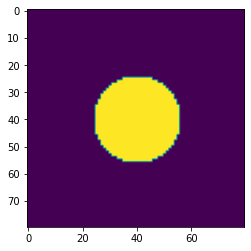

In [2]:
Nx = 80;
Ny = 80;
N = np.array([Nx, Ny]);

eps_r = np.ones(N);

a = np.array([1,1])*1e-6;
dL = a/N;
radius = 0.2*1e-6;
## put in a circle;
ci = int(Nx/2); cj= int(Ny/2);

cr = (radius/a[0])*Nx;
I,J=np.meshgrid(np.arange(eps_r.shape[0]),np.arange(eps_r.shape[1]));

print(eps_r.shape)
dist = np.sqrt((I-ci)**2 + (J-cj)**2);
#print(np.where(dist<cr))
eps_r[np.where(dist<cr)] = 8.9;

plt.imshow(eps_r)

fd = grid.FiniteDifferenceGrid(dL,N)

print(fd.Dxf.shape, dL)

st = structure.Structure(eps_r, a);
print(st.dL, dL)

In [3]:
eigen2d = eigen_w.EigenOmega2D(st);
A = eigen2d.A;

wvlen = 1e-6;
omega = 2*np.pi*C0/(wvlen);

eigvals, eigvecs = la.eigs(A, sigma = omega**2, k = 10)

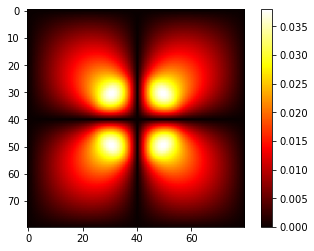

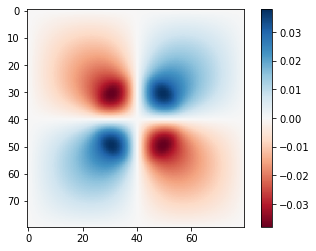

In [4]:
plt.imshow(np.abs(eigvecs[:,0].reshape(N)), cmap = 'hot')
plt.colorbar();
plt.show();
plt.imshow(np.real(eigvecs[:,0].reshape(N)), cmap = 'RdBu')
plt.colorbar();

## Photonic Band Structure
#### Ky = 0

In [5]:
from scipy.sparse.linalg import splu
wvlen = 1e-6;
omega = 2*np.pi*C0/wvlen;
eigk = eigen_k.EigenK2D(st, polarization = 'TE')
eigk.make_operator_components(omega);
print(fd.Dxf.shape)
OA = eigk.OA;
OB = eigk.OB;
# plt.figure(figsize = (10,10));
# plt.spy(OB, markersize = 0.5);

B = splu(OA-OB)
print(B.L.count_nonzero())



(6400, 6400)
682140


/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [6]:
eigvals, eigvecs = la.eigs(OA, k = 10, M = OB, sigma= 0)
print(eigvals)

[-1.38853715e+06+3.87330536e-02j -7.66864517e-04-1.45115502e+06j
  1.38853715e+06+4.05971266e-02j -3.55844721e-04+1.45115512e+06j
  3.15096777e+06-1.07991984e+06j  3.15096783e+06+1.07991975e+06j
 -3.15096774e+06-1.07991984e+06j -3.15096778e+06+1.07991976e+06j
 -4.88098022e+06+6.81175368e-02j  4.88098012e+06+1.94242194e-02j]


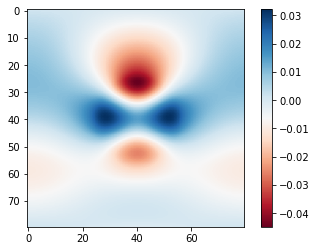

In [7]:
plt.imshow(np.real(np.reshape(eigvecs[0:np.prod(N),5], N, order = 'F')), cmap = 'RdBu')
#plt.imshow(np.real(np.reshape(eigvecs[np.prod(N):,4], N, order = 'F')), cmap = 'RdBu')

plt.colorbar();

In [8]:
#wvlen_scan = np.linspace(1,10,60);
wvlen_scan = np.logspace(np.log10(1), np.log10(10),501)*1e-6
spectra = [];
for c,wvlen in enumerate(wvlen_scan):
    omega = 2*np.pi*C0/(wvlen);
    
    #eigvals, eigvecs = eigk.eigensolve(omega, Ky, num_modes = 10)
    eigk.make_operator_components(omega);
    
    OA = eigk.OA;
    OB = eigk.OB;
    
    eigvals, eigvecs = la.eigs(OA, k = 10, M = OB, sigma= 0)

    
    spectra.append(eigvals);
    if(c%10 == 0):
        print(c, wvlen)
spectra = np.array(spectra)

0 1e-06
10 1.0471285480508996e-06
20 1.096478196143185e-06
30 1.1481536214968827e-06
40 1.202264434617413e-06
50 1.2589254117941672e-06
60 1.318256738556407e-06
70 1.3803842646028846e-06
80 1.4454397707459273e-06
90 1.5135612484362082e-06
100 1.5848931924611134e-06
110 1.6595869074375605e-06
120 1.7378008287493753e-06
130 1.8197008586099834e-06
140 1.905460717963247e-06
150 1.9952623149688796e-06
160 2.0892961308540394e-06
170 2.1877616239495526e-06
180 2.290867652767773e-06
190 2.39883291901949e-06
200 2.51188643150958e-06
210 2.6302679918953817e-06
220 2.7542287033381663e-06
230 2.884031503126606e-06
240 3.019951720402016e-06
250 3.162277660168379e-06
260 3.311311214825911e-06
270 3.4673685045253164e-06
280 3.6307805477010137e-06
290 3.801893963205611e-06
300 3.981071705534972e-06
310 4.168693834703353e-06
320 4.36515832240166e-06
330 4.57088189614875e-06
340 4.786300923226383e-06
350 5.011872336272723e-06
360 5.248074602497725e-06
370 5.495408738576246e-06
380 5.754399373371569e-06


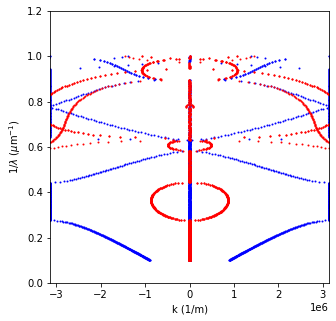

In [20]:
plt.figure(figsize = (5,5));
plt.plot(np.real(spectra), 1/wvlen_scan*1e-6, '.b', markersize = 2);
plt.plot(np.imag(spectra),  1/wvlen_scan*1e-6, '.r', markersize = 2);
#plt.xlim((-30e6, 50e6))
plt.ylim(0,1.2)
plt.xlim(-np.pi*1e6, np.pi*1e6)
plt.xlabel('k (1/m)')
plt.ylabel('1/$\lambda$ ($\mu$m$^{-1}$)')
plt.savefig('../img/TE_polarization.png',dpi = 300)
plt.show();


## TM Scan

In [16]:
eigk = eigen_k.EigenK2D(st, polarization = 'TM')
eigk.make_operator_components(omega);
print(fd.Dxf.shape)
OA = eigk.OA;
OB = eigk.OB;


(6400, 6400)


In [17]:
#wvlen_scan = np.linspace(1,10,60);
tm_spectra = [];
for c,wvlen in enumerate(wvlen_scan):
    omega = 2*np.pi*C0/(wvlen);
    
    #eigvals, eigvecs = eigk.eigensolve(omega, Ky, num_modes = 10)
    eigk.make_operator_components(omega);
    
    OA = eigk.OA;
    OB = eigk.OB;
    
    eigvals, eigvecs = la.eigs(OA, k = 10, M = OB, sigma= 0)

    
    tm_spectra.append(eigvals);
    if(c%10 == 0):
        print(c, wvlen)
tm_spectra = np.array(tm_spectra)

0 1e-06
10 1.0471285480508996e-06
20 1.096478196143185e-06
30 1.1481536214968827e-06
40 1.202264434617413e-06
50 1.2589254117941672e-06
60 1.318256738556407e-06
70 1.3803842646028846e-06
80 1.4454397707459273e-06
90 1.5135612484362082e-06
100 1.5848931924611134e-06
110 1.6595869074375605e-06
120 1.7378008287493753e-06
130 1.8197008586099834e-06
140 1.905460717963247e-06
150 1.9952623149688796e-06
160 2.0892961308540394e-06
170 2.1877616239495526e-06
180 2.290867652767773e-06
190 2.39883291901949e-06
200 2.51188643150958e-06
210 2.6302679918953817e-06
220 2.7542287033381663e-06
230 2.884031503126606e-06
240 3.019951720402016e-06
250 3.162277660168379e-06
260 3.311311214825911e-06
270 3.4673685045253164e-06
280 3.6307805477010137e-06
290 3.801893963205611e-06
300 3.981071705534972e-06
310 4.168693834703353e-06
320 4.36515832240166e-06
330 4.57088189614875e-06
340 4.786300923226383e-06
350 5.011872336272723e-06
360 5.248074602497725e-06
370 5.495408738576246e-06
380 5.754399373371569e-06


<ipython-input-34-a59f9cf7c14f>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Y, eps_r);


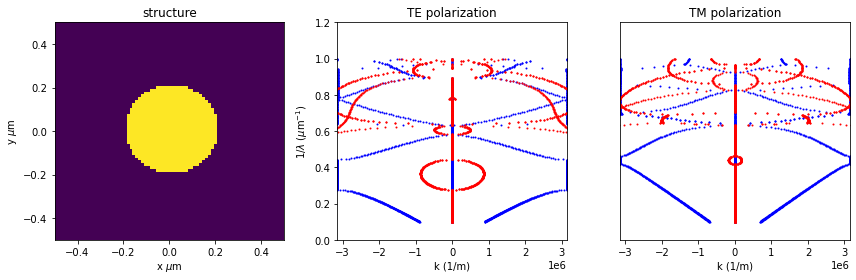

In [34]:
plt.figure(figsize = (12,4));
x = np.linspace(-0.5, 0.5, Nx)
y = np.linspace(-0.5, 0.5, Ny)
X, Y = np.meshgrid(x,y);
plt.subplot(131)
plt.pcolormesh(X,Y, eps_r);
plt.xlabel('x $\mu$m')
plt.ylabel('y $\mu$m')
plt.title('structure')
plt.subplot(132)
plt.plot(np.real(spectra), 1/wvlen_scan*1e-6, '.b', markersize = 2);
plt.plot(np.imag(spectra),  1/wvlen_scan*1e-6, '.r', markersize = 2);
#plt.xlim((-30e6, 50e6))
plt.ylim(0,1.2)
plt.xlim(-np.pi*1e6, np.pi*1e6)
plt.xlabel('k (1/m)')
plt.ylabel('1/$\lambda$ ($\mu$m$^{-1}$)')
plt.title('TE polarization')

plt.subplot(133);
plt.plot(np.real(tm_spectra), 1/wvlen_scan*1e-6, '.b', markersize = 2);
plt.plot(np.imag(tm_spectra),  1/wvlen_scan*1e-6, '.r', markersize = 2);
#plt.xlim((-30e6, 50e6))
plt.ylim(0,1.2)
plt.xlim(-np.pi*1e6, np.pi*1e6)
plt.ylim(0,1.2)
plt.xlim(-np.pi*1e6, np.pi*1e6)
plt.xlabel('k (1/m)')
#plt.ylabel('1/$\lambda$ ($\mu$m$^{-1}$)')
plt.yticks([])
plt.savefig('../img/2d_phc_band_structure.png',dpi = 300)
plt.tight_layout();
plt.title('TM polarization')
plt.show();


